In [93]:
# import wget
# import zipfile
# import os


# testdata = wget.download("https://datasets.tardis.dev/v1/binance/book_snapshot_25/2025/01/01/DOGEUSDT.csv.gz")
# df = pd.read_csv("DOGEUSDT.csv.gz")
# print(df)

# # Path to the downloaded zip file
# zip_file_path = 'DOGEUSDT-trades-2025-01-01.zip'

# # Extract the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # List all files in the zip
#     zip_ref.printdir()

#     # Extract all the contents into the current directory
#     zip_ref.extractall()
    
# path2 = "D:/Documents/CLS/thesis/MM_sandbox/DOGEUSDT-trades-2025-01-01.csv"
# df2 = pd.read_csv(path2)
# print(df2)

# df2 = df2.sort_values("time")
# df2["time"] = pd.to_datetime(df2["time"], unit="ms")

In [94]:
# Packages
from tardis_dev import datasets
import nest_asyncio
import pandas as pd

from hftbacktest.data.utils import tardis
from numba import njit
from hftbacktest import BUY_EVENT
import numpy as np
from hftbacktest import BacktestAsset, ROIVectorMarketDepthBacktest

from matplotlib import pyplot as plt

nest_asyncio.apply()

In [95]:
# ######## Downloading DOGEUSDT data from Tardis for 2025-01-01 #######
# datasets.download(
#     exchange="binance",
#     data_types=["trades", "incremental_book_L2", "book_snapshot_25"],
#     from_date="2025-01-01",
#     to_date="2025-01-02",   # end date is exclusive
#     symbols=["DOGEUSDT"],
#     # api_key="YOUR_API_KEY",  # omit for 1st-of-month if it works without key
# )

# df1 = pd.read_csv("datasets/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv.gz")
# df2 = pd.read_csv("datasets/binance_incremental_book_L2_2025-01-01_DOGEUSDT.csv.gz")
# df3 = pd.read_csv("datasets/binance_trades_2025-01-01_DOGEUSDT.csv.gz")
# print(df1)
# print(df2)
# print(df3)

In [96]:
# # Converting tardis data
# tardis.convert(
#     input_files=[
#         "datasets/binance_trades_2025-01-01_DOGEUSDT.csv.gz",
#         "datasets/binance_incremental_book_L2_2025-01-01_DOGEUSDT.csv.gz",
#         "datasets/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv.gz",
#     ],
#     output_filename="data/dogeusdt_20250101.npz",
# )

In [97]:
@njit
def measure_trading_intensity_and_volatility(hbt):
    tick_size = hbt.depth(0).tick_size
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan

    # Checks every 100 milliseconds.
    while hbt.elapse(100_000_000) == 0:
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for last_trade in hbt.last_trades(0):
                trade_price_tick = last_trade.px / tick_size

                if last_trade.ev & BUY_EVENT == BUY_EVENT:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth

        hbt.clear_last_trades(0)

        depth = hbt.depth(0)

        best_bid_tick = depth.best_bid_tick
        best_ask_tick = depth.best_ask_tick

        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (best_bid_tick + best_ask_tick) / 2.0

        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick

        t += 1
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
    return arrival_depth[:t], mid_price_chg[:t]

In [98]:
@njit
def measure_trading_intensity(order_arrival_depth, out):
    max_tick = 0
    for depth in order_arrival_depth:
        if not np.isfinite(depth):
            continue

        # Sets the tick index to 0 for the nearest possible best price
        # as the order arrival depth in ticks is measured from the mid-price
        tick = round(depth) - 1

        # In a fast-moving market, buy trades can occur below the mid-price (and vice versa for sell trades)
        # since the mid-price is measured in a previous time-step;
        # however, to simplify the problem, we will exclude those cases.
        if tick < 0 or tick >= len(out):
            continue

        # All of our possible quotes within the order arrival depth,
        # excluding those at the same price, are considered executed.
        out[:tick] += 1

        max_tick = max(max_tick, tick)
    return out[:max_tick]

In [99]:
asset = (
    BacktestAsset()
        .data([
            'data/dogeusdt_20250101.npz'
        ])
        # .initial_snapshot('data/dogeusdt_20250101_eod.npz')
        .linear_asset(1.0)
        # .intp_order_latency([
        #     'latency/feed_latency_20250101.npz'
        # ])
        .power_prob_queue_model(2.0)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.01)
        .lot_size(0.001)
        .roi_lb(0.0)
        .roi_ub(3000.0)
        .last_trades_capacity(10000)
)

hbt = ROIVectorMarketDepthBacktest([asset])

arrival_depth, mid_price_chg = measure_trading_intensity_and_volatility(hbt)

_ = hbt.close()

In [100]:
tmp = np.zeros(500, np.float64)

# Measures trading intensity (lambda) for the first 10-minute window.
lambda_ = measure_trading_intensity(arrival_depth[:6_000], tmp)

# Since it is measured for a 10-minute window, divide by 600 to convert it to per second.
lambda_ /= 600

# Creates ticks from the mid-price.
ticks = np.arange(len(lambda_))

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_13960\1237891454.py:2: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('$ \delta $ (ticks from the mid-price)')


Text(0, 0.5, 'Count (per second)')

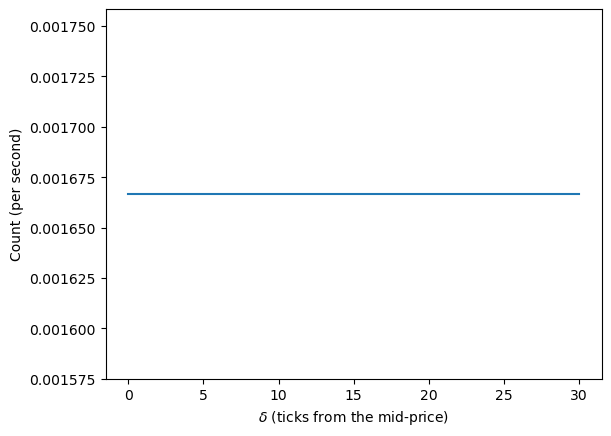

In [101]:
plt.plot(ticks, lambda_)
plt.xlabel('$ \delta $ (ticks from the mid-price)')
plt.ylabel('Count (per second)')

In [102]:
@njit
def linear_regression(x, y):
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = (w * sxy - sx * sy) / (w * sx2 - sx**2)
    intercept = (sy - slope * sx) / w
    return slope, intercept

In [103]:
y = np.log(lambda_)
k_, logA = linear_regression(ticks, y)
A = np.exp(logA)
k = -k_

print('A={}, k={}'.format(A, k))

A=0.0016666666666666594, k=-1.8928089527012035e-16


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_13960\724309136.py:3: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('$ \delta $ (ticks from the mid-price)')


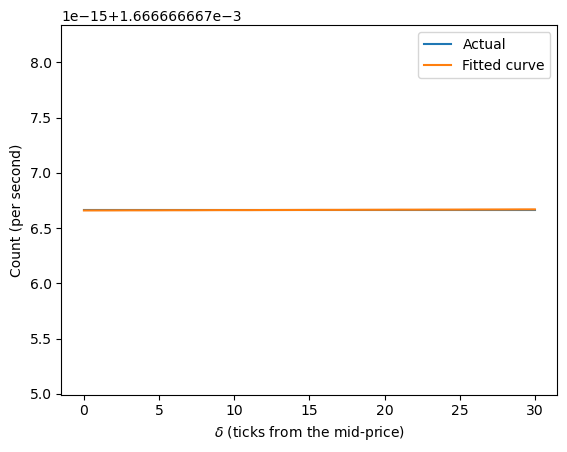

In [104]:
plt.plot(lambda_)
plt.plot(A * np.exp(-k * ticks))
plt.xlabel('$ \delta $ (ticks from the mid-price)')
plt.ylabel('Count (per second)')
plt.legend(['Actual', 'Fitted curve'])

In [105]:
# Refits for the range un to 70 ticks.
x_shallow = ticks[:70]
lambda_shallow = lambda_[:70]

y = np.log(lambda_shallow)
k_, logA = linear_regression(x_shallow, y)
A = np.exp(logA)
k = -k_

print('A={}, k={}'.format(A, k))

A=0.0016666666666666594, k=-1.8928089527012035e-16


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_13960\303205158.py:3: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('$ \delta $ (ticks from the mid-price)')


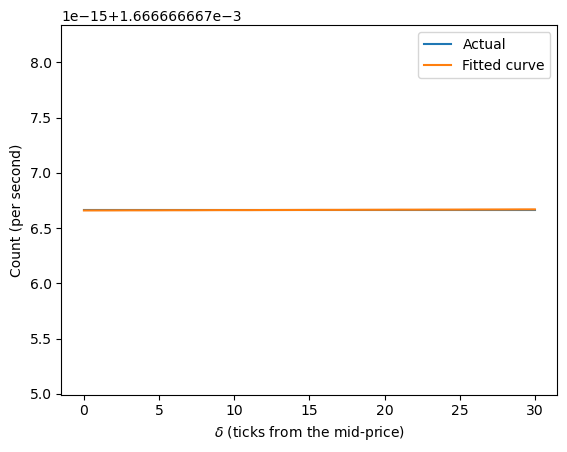

In [106]:
plt.plot(lambda_shallow)
plt.plot(A * np.exp(-k * x_shallow))
plt.xlabel('$ \delta $ (ticks from the mid-price)')
plt.ylabel('Count (per second)')
plt.legend(['Actual', 'Fitted curve'])

In [107]:
# Since we need volatility in ticks per square root of a second and our measurement is every 100ms,
# multiply by the square root of 10.
volatility = np.nanstd(mid_price_chg) * np.sqrt(10)
print(volatility)

1.3235073072490586


In [108]:
@njit
def compute_coeff(xi, gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = 1 / (xi * delta) * np.log(1 + xi * delta * inv_k)
    c2 = np.sqrt(np.divide(gamma, 2 * A * delta * k) * ((1 + xi * delta * inv_k) ** (k / (xi * delta) + 1)))
    return c1, c2

In [109]:
gamma = 0.05
delta = 1
volatility = 10.69

c1, c2 = compute_coeff(gamma, gamma, delta, A, k)

half_spread_tick = 1 * c1 + 1 / 2 * c2 * volatility
skew = c2 * volatility
print('half_spread_tick={}, skew={}'.format(half_spread_tick, skew))

half_spread_tick=nan, skew=nan
